In [5]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import rasterio
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms
from sklearn.metrics import precision_score, recall_score, f1_score

In [6]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [19]:
# Parameters
BATCH_SIZE = 8
EPOCHS = 30
LR = 5e-4
IMG_HEIGHT, IMG_WIDTH = 128, 128
NUM_CHANNELS = 12

In [ ]:
# Data loading and preprocessing
def load_data(image_dir, label_dir):
    filenames = sorted([f.split('.')[0] for f in os.listdir(image_dir) if f.endswith('.tif')])
    images, labels = [], []
    for img_id in filenames:
        img_path = os.path.join(image_dir, f"{img_id}.tif")
        label_path = os.path.join(label_dir, f"{img_id}.png")

        # Load image (12 channels)
        with rasterio.open(img_path) as src:
            image = src.read()  # shape: (12, H, W)
            image = np.moveaxis(image, 0, -1)  # (H, W, 12)

        # Load label (binary mask)
        label = np.array(Image.open(label_path).convert("L"))  # (H, W)
        label = (label > 0).astype(np.float32)

        # Band-wise normalization (standard scaling)
        image = image.astype(np.float32)
        for c in range(NUM_CHANNELS):
            mean = image[:, :, c].mean()
            std = image[:, :, c].std() + 1e-6 # to avoid divison by zero
            image[:, :, c] = (image[:, :, c] - mean) / std

        images.append(image)
        labels.append(label)

    return images, labels

In [ ]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=90),
])

def prepare_dataset(images, labels):
    dataset = []
    for image, label in zip(images, labels):
        # Convert to tensor first
        image = torch.from_numpy(image).permute(2, 0, 1).float()  # (C, H, W)
        label = torch.from_numpy(label).unsqueeze(0).float()      # (1, H, W)

        # Apply torchvision transforms to image and label together
        seed = np.random.randint(2147483647)  # Random seed for consistency
        torch.manual_seed(seed)
        image = transform(image)
        torch.manual_seed(seed)  # Same seed for label
        label = transform(label)

        # Custom brightness/contrast adjustment for 12-channel images
        if np.random.rand() < 0.3:  # Apply with 30% probability
            brightness_factor = np.random.uniform(0.8, 1.2)
            contrast_factor = np.random.uniform(0.8, 1.2)
            # Apply brightness: image = image * brightness_factor
            image = image * brightness_factor
            # Apply contrast: image = (image - mean) * contrast_factor + mean
            mean = image.mean(dim=(1, 2), keepdim=True)
            image = (image - mean) * contrast_factor + mean
            
        dataset.append((image, label))
    return dataset

# Visualize bands
def visualize_bands(image, num_channels=12):
    image = image.permute(1, 2, 0).numpy()  # (H, W, C)
    plt.figure(figsize=(15, 10))
    for i in range(num_channels):
        plt.subplot(3, 4, i+1)
        plt.imshow(image[:, :, i], cmap='gray')
        plt.title(f'Band {i+1}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [ ]:
# U-Net model
def create_unet_model(in_channels=12, out_channels=1):
    def conv_block(in_c, out_c):
        """
            Two 3x3 convolutional layers.
            Batch normalization after each convolution.
            ReLU activation
            30% Dropout
        """
        return nn.Sequential(
            nn.Conv2d(in_c, out_c, 3, padding=1),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True),

            nn.Conv2d(out_c, out_c, 3, padding=1),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3)
        )

    model = nn.Module()
    # Encoder
    """
    Four convolutional blocks with increasing channels,
    followed by 2x2 maxpooling to downsample.
    """
    model.encoder1 = conv_block(in_channels, 64)
    model.pool1 = nn.MaxPool2d(2)
    model.encoder2 = conv_block(64, 128)
    model.pool2 = nn.MaxPool2d(2)
    model.encoder3 = conv_block(128, 256)
    model.pool3 = nn.MaxPool2d(2)
    model.encoder4 = conv_block(256, 512)
    model.pool4 = nn.MaxPool2d(2)

    # Bottleneck
    model.bottleneck = conv_block(512, 1024) # to capture deep features

    # Decoder
    """
    Four upsampling blocks with decreasing channels.
    """
    model.upconv4 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
    model.decoder4 = conv_block(1024, 512)
    model.upconv3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
    model.decoder3 = conv_block(512, 256)
    model.upconv2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
    model.decoder2 = conv_block(256, 128)
    model.upconv1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
    model.decoder1 = conv_block(128, 64)

    model.output = nn.Conv2d(64, out_channels, kernel_size=1) # single channel output

    def forward(self, x):
        e1 = self.encoder1(x)
        e2 = self.encoder2(self.pool1(e1))
        e3 = self.encoder3(self.pool2(e2))
        e4 = self.encoder4(self.pool3(e3))
        
        b = self.bottleneck(self.pool4(e4))

        d4 = self.upconv4(b)
        d4 = self.decoder4(torch.cat([d4, e4], dim=1))
        d3 = self.upconv3(d4)
        d3 = self.decoder3(torch.cat([d3, e3], dim=1))
        d2 = self.upconv2(d3)
        d2 = self.decoder2(torch.cat([d2, e2], dim=1))
        d1 = self.upconv1(d2)
        d1 = self.decoder1(torch.cat([d1, e1], dim=1))

        return self.output(d1)

    model.forward = forward.__get__(model, nn.Module)
    return model.to(device)


In [11]:
# Evaluation metrics
def calculate_metrics(preds, targets, threshold=0.5):
    preds = torch.sigmoid(preds)
    preds = (preds > threshold).float()
    targets = (targets > 0.5).float()

    # IoU
    intersection = (preds * targets).sum(dim=(1, 2, 3))
    union = preds.sum(dim=(1, 2, 3)) + targets.sum(dim=(1, 2, 3)) - intersection
    iou = (intersection + 1e-6) / (union + 1e-6)
    iou = iou.mean().item()

    # Flatten for sklearn metrics
    preds_flat = preds.cpu().numpy().flatten()
    targets_flat = targets.cpu().numpy().flatten()
    precision = precision_score(targets_flat, preds_flat, zero_division=0)
    recall = recall_score(targets_flat, preds_flat, zero_division=0)
    f1 = f1_score(targets_flat, preds_flat, zero_division=0)

    return iou, precision, recall, f1

c:\Python312\Lib\site-packages\rasterio\__init__.py:368: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


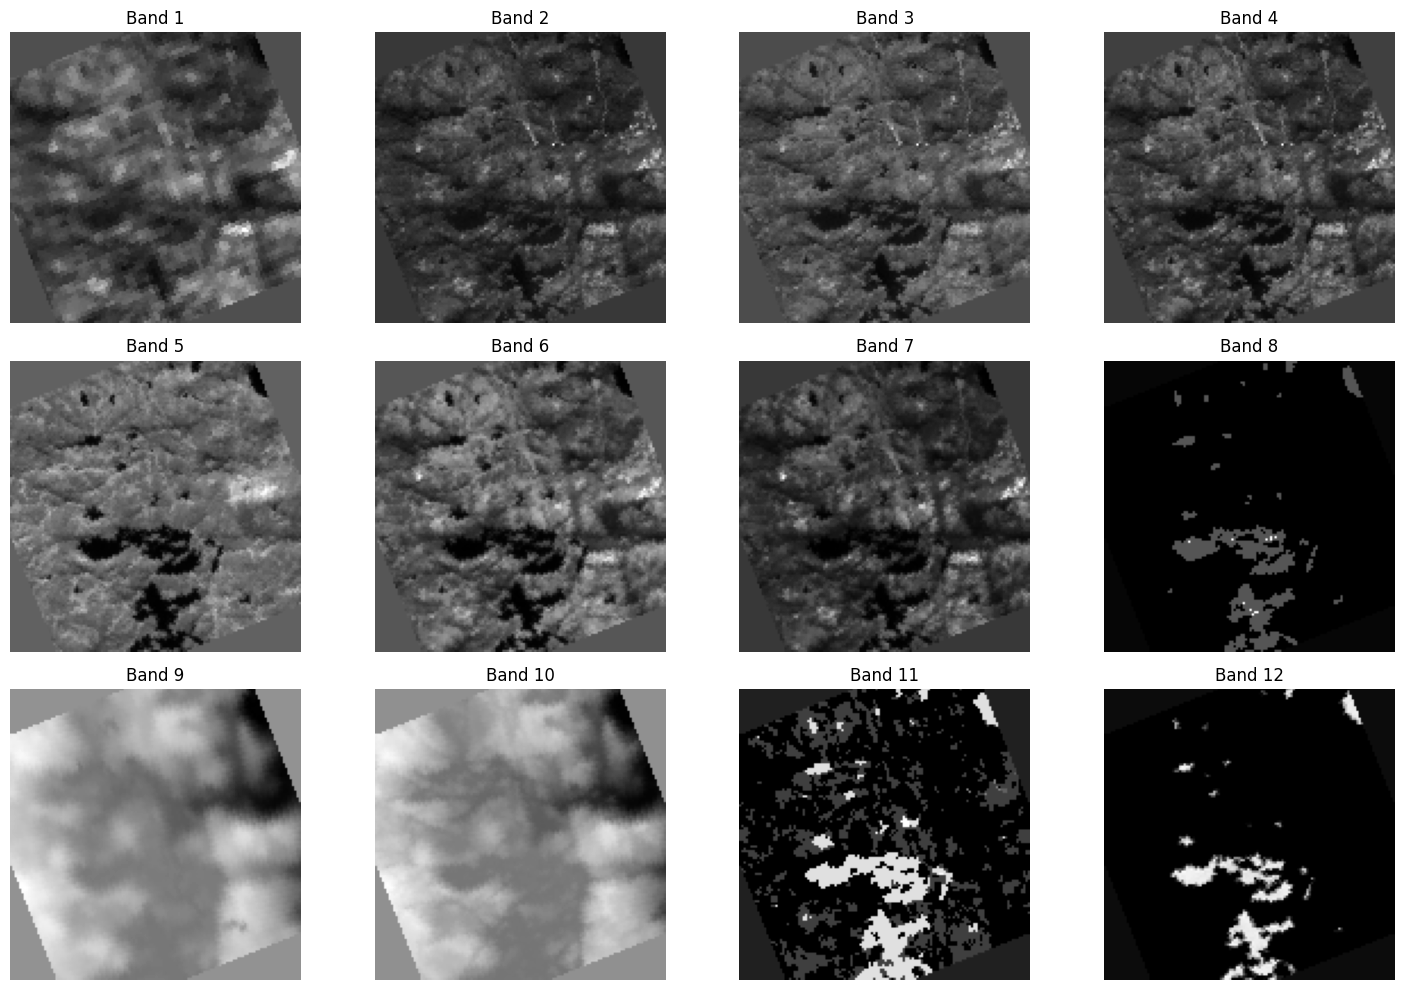

Epoch [1/30], Loss: 0.4225, IoU: 0.3590, Precision: 0.6930, Recall: 0.6590, F1: 0.6406
Epoch [2/30], Loss: 0.3194, IoU: 0.4516, Precision: 0.7881, Recall: 0.6914, F1: 0.7157
Epoch [3/30], Loss: 0.2789, IoU: 0.4739, Precision: 0.7933, Recall: 0.7207, F1: 0.7407
Epoch [4/30], Loss: 0.2608, IoU: 0.4975, Precision: 0.8111, Recall: 0.7241, F1: 0.7533
Epoch [5/30], Loss: 0.2487, IoU: 0.4916, Precision: 0.8296, Recall: 0.7331, F1: 0.7736
Epoch [6/30], Loss: 0.2294, IoU: 0.5140, Precision: 0.8333, Recall: 0.7563, F1: 0.7859
Epoch [7/30], Loss: 0.2393, IoU: 0.5049, Precision: 0.8506, Recall: 0.7401, F1: 0.7800
Epoch [8/30], Loss: 0.2320, IoU: 0.5009, Precision: 0.8173, Recall: 0.7474, F1: 0.7580
Epoch [9/30], Loss: 0.2260, IoU: 0.5386, Precision: 0.8369, Recall: 0.7316, F1: 0.7715
Epoch [10/30], Loss: 0.2117, IoU: 0.5429, Precision: 0.8508, Recall: 0.7471, F1: 0.7893
Epoch [11/30], Loss: 0.1982, IoU: 0.5423, Precision: 0.8613, Recall: 0.7649, F1: 0.8050
Epoch [12/30], Loss: 0.2195, IoU: 0.5182,

In [21]:
# Training pipeline
def train_model():
    # Load and prepare data
    images, labels = load_data('data/images', 'data/labels')
    dataset = prepare_dataset(images, labels)
    train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

    # Visualize first image bands
    visualize_bands(dataset[0][0])

    # Initialize model, loss, and optimizer
    model = create_unet_model(in_channels=NUM_CHANNELS, out_channels=1)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=LR)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

    # Training loop
    for epoch in range(EPOCHS):
        model.train()
        epoch_loss = 0
        epoch_iou = 0
        epoch_precision = 0
        epoch_recall = 0
        epoch_f1 = 0

        for images, masks in train_loader:
            images, masks = images.to(device), masks.to(device)
            preds = model(images)

            loss = criterion(preds, masks)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            iou, precision, recall, f1 = calculate_metrics(preds, masks)
            epoch_loss += loss.item()
            epoch_iou += iou
            epoch_precision += precision
            epoch_recall += recall
            epoch_f1 += f1

        # Average metrics
        num_batches = len(train_loader)
        epoch_loss /= num_batches
        epoch_iou /= num_batches
        epoch_precision /= num_batches
        epoch_recall /= num_batches
        epoch_f1 /= num_batches

        # Step scheduler
        scheduler.step(epoch_loss)

        print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {epoch_loss:.4f}, IoU: {epoch_iou:.4f}, "
              f"Precision: {epoch_precision:.4f}, Recall: {epoch_recall:.4f}, F1: {epoch_f1:.4f}")

# Run the pipeline
train_model()

# Pretrained Model

In [ ]:
import segmentation_models_pytorch as smp

# Parameters for pretrained model (same as previous for fair comparison)
BATCH_SIZE = 8
EPOCHS = 30
LR = 5e-4
NUM_CHANNELS = 12
BACKBONE = 'resnet34'

In [ ]:
# Create pretrained U-Net model
def create_unet_pretrained_model(in_channels=12, out_channels=1):
    model = smp.Unet(
        encoder_name=BACKBONE,         # Use ResNet34 backbone
        encoder_weights='imagenet',    # Pretrained on ImageNet
        in_channels=in_channels,       # 12 channels for multispectral input
        classes=out_channels,          # 1 output channel for binary segmentation
        activation=None                # No activation (logits for BCEWithLogitsLoss)
    )
    # Modify encoder for 12 channels (ImageNet weights are for 3 channels)
    original_conv1 = model.encoder.conv1
    new_conv1 = nn.Conv2d(
        in_channels=in_channels,
        out_channels=original_conv1.out_channels,
        kernel_size=original_conv1.kernel_size,
        stride=original_conv1.stride,
        padding=original_conv1.padding,
        bias=original_conv1.bias is not None
    )
    model.encoder.conv1 = new_conv1
    return model.to(device)

c:\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Python312\Lib\site-packages\rasterio\__init__.py:368: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


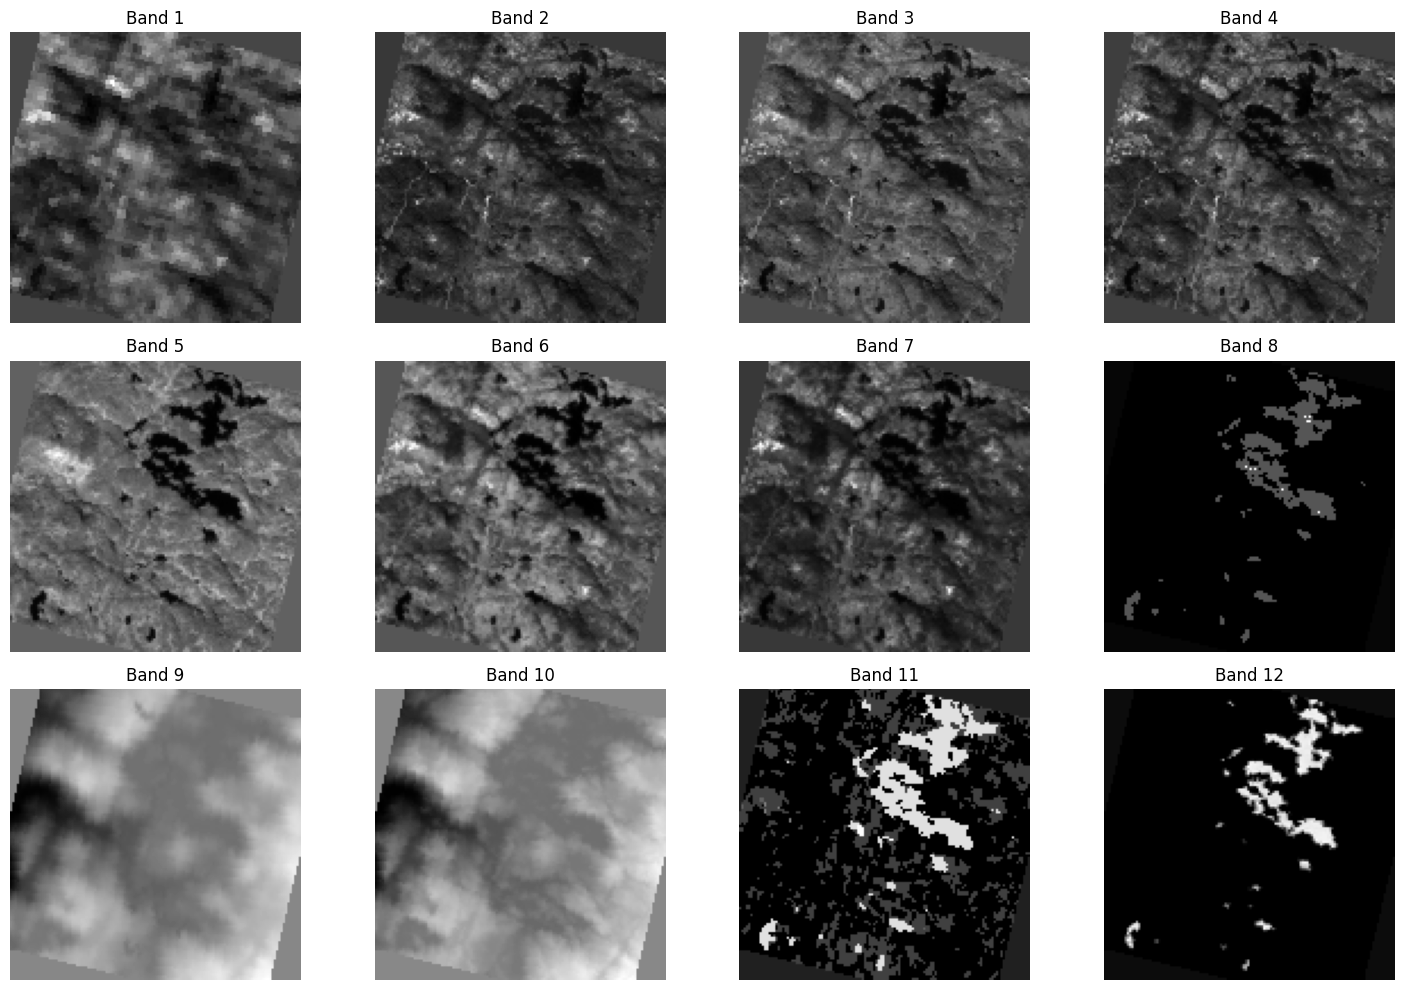

c:\Python312\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\nadak\.cache\huggingface\hub\models--smp-hub--resnet34.imagenet. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Pretrained Model - Epoch [1/30], Loss: 0.4752, IoU: 0.2480, Precision: 0.6458, Recall: 0.4541, F1: 0.5107
Pretrained Model - Epoch [2/30], Loss: 0.3520, IoU: 0.3446, Precision: 0.7718, Recall: 0.5923, F1: 0.6443
Pretrained Model - Epoch [3/30], Loss: 0.3066, IoU: 0.4120, Precision: 0.8283, Recall: 0.5743, F1: 0.6664
Pretrained Model - Epoch [4/30], Loss: 0.2868, IoU: 0.3943, Precision: 0.7842, Recall: 0.6697, F1: 0.7029
Pretrained Model - Epoch [5/30], Loss: 0.2541, IoU: 0.4439, Precision: 0.8125, Recall: 0.7155, F1: 0.7465
Pretrained Model - Epoch [6/30], Loss: 0.2471, IoU: 0.4784, Precision: 0.8264, Recall: 0.7082, F1: 0.7512
Pretrained Model - Epoch [7/30], Loss: 0.2444, IoU: 0.4516, Precision: 0.7942, Recall: 0.7520, F1: 0.7626
Pretrained Model - Epoch [8/30], Loss: 0.2415, IoU: 0.4828, Precision: 0.8334, Recall: 0.7185, F1: 0.7573
Pretrained Model - Epoch [9/30], Loss: 0.2213, IoU: 0.4756, Precision: 0.8056, Recall: 0.7792, F1: 0.7817
Pretrained Model - Epoch [10/30], Loss: 0.2078

In [ ]:
def train_pretrained_model():
    # Load and prepare data
    images, labels = load_data('data/images', 'data/labels')
    dataset = prepare_dataset(images, labels)
    train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
    
    # Visualize first image bands
    visualize_bands(dataset[0][0])
    
    # Initialize model, loss, and optimizer
    model = create_unet_pretrained_model(in_channels=NUM_CHANNELS, out_channels=1)
    criterion = nn.BCEWithLogitsLoss()
    
    # Freeze encoder for first 10 epochs
    for param in model.encoder.parameters():
        param.requires_grad = False
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=LR)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.3, patience=3)
    
    # Training loop
    for epoch in range(EPOCHS):
        model.train()
        # Unfreeze encoder after 10 epochs
        if epoch == 10:
            for param in model.encoder.parameters():
                param.requires_grad = True
            optimizer = optim.Adam(model.parameters(), lr=LR / 2)  # Lower LR for fine-tuning
        epoch_loss = 0
        epoch_iou = 0
        epoch_precision = 0
        epoch_recall = 0
        epoch_f1 = 0
        for images, masks in train_loader:
            images, masks = images.to(device), masks.to(device)
            preds = model(images)
            loss = criterion(preds, masks)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            iou, precision, recall, f1 = calculate_metrics(preds, masks)
            epoch_loss += loss.item()
            epoch_iou += iou
            epoch_precision += precision
            epoch_recall += recall
            epoch_f1 += f1
        # Average metrics
        num_batches = len(train_loader)
        epoch_loss /= num_batches
        epoch_iou /= num_batches
        epoch_precision /= num_batches
        epoch_recall /= num_batches
        epoch_f1 /= num_batches
        # Step scheduler
        scheduler.step(epoch_loss)
        print(f"Pretrained Model - Epoch [{epoch+1}/{EPOCHS}], Loss: {epoch_loss:.4f}, IoU: {epoch_iou:.4f}, "
              f"Precision: {epoch_precision:.4f}, Recall: {epoch_recall:.4f}, F1: {epoch_f1:.4f}")

# Run the pretrained model pipeline
train_pretrained_model()